<a href="https://colab.research.google.com/github/ronaldocristover/Breast-Cancer-Machine-Learning-Example/blob/master/BACKUPof_RFM_tec_kpi_clean_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing


import numpy as np

In [ ]:
# Download tec_kpi_clean
# Source: https://drive.google.com/file/d/1CxkntxdzrUIGZX7g1_v8z6bC2MxKpaBm/view?usp=sharing
!gdown 1CxkntxdzrUIGZX7g1_v8z6bC2MxKpaBm

Downloading...
From: https://drive.google.com/uc?id=1CxkntxdzrUIGZX7g1_v8z6bC2MxKpaBm
To: /content/tec_kpi_clean.csv
100% 2.63M/2.63M [00:00<00:00, 232MB/s]


In [ ]:
import pandas as pd
df = pd.read_csv('/content/tec_kpi_clean.csv', index_col=[0], delimiter = ',')
df['date'] = pd.to_datetime(df['date'])
df['total_comm'] = df['total_comm'] / 10000
df.set_index('date')

df.head()

,date,customer_id,sales_id,total_comm
0,2021-05-01,18,8,8.7500
1,2021-05-01,19,8,8.8500
2,2021-05-01,20,8,6.9700
3,2021-05-01,21,8,52.5766
4,2021-05-01,22,8,5.1780


In [ ]:
df.head()

,date,customer_id,sales_id,total_comm
0,2021-05-01,18,8,8.7500
1,2021-05-01,19,8,8.8500
2,2021-05-01,20,8,6.9700
3,2021-05-01,21,8,52.5766
4,2021-05-01,22,8,5.1780


In [ ]:
# Menghitung panjang data
len(df.index)                                                                                                                                   

90564

In [ ]:
df['year_month'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,customer_id,sales_id,total_comm,year_month,year,month
0,2021-05-01,18,8,8.7500,2021-05-01,2021,5
1,2021-05-01,19,8,8.8500,2021-05-01,2021,5
2,2021-05-01,20,8,6.9700,2021-05-01,2021,5
3,2021-05-01,21,8,52.5766,2021-05-01,2021,5
4,2021-05-01,22,8,5.1780,2021-05-01,2021,5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


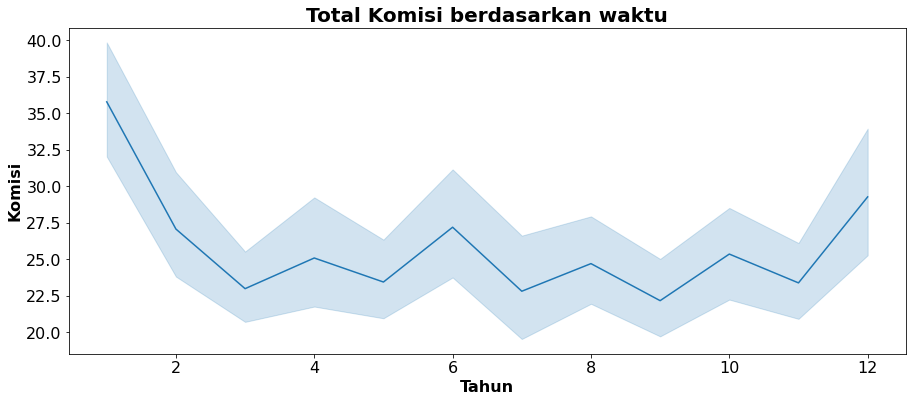

In [ ]:
# Menampilkan grafik komisi berdasarkan waktu

fig, ax = plt.subplots(figsize=(15, 6))
df_2021 = df[df['year'] == 2021]
# df_2021['total_comm'] = df_2021['total_comm']  * 10000
sns.lineplot(df_2021['month'], df_2021['total_comm'] )

ax.set_title('Total Komisi berdasarkan waktu', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Tahun', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Komisi', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# Menghitung RFM (Recency Frequency Monetary) Model

In [ ]:
# Calculate Recency
df_recency = df.groupby(by='customer_id',
                        as_index=False)['date'].max()
df_recency.columns = ['customer_id', 'last_purchase_date']

recent_date = df_recency['last_purchase_date'].max()
df_recency['recency'] = df_recency['last_purchase_date'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,customer_id,last_purchase_date,recency
0,1,2021-09-20,440
1,2,2022-11-04,30
2,5,2021-09-17,443
3,7,2022-11-03,31
4,9,2022-11-02,32


In [ ]:
# Calculate Frequency
frequency_df = df.drop_duplicates().groupby(
    by=['customer_id'], as_index=False)['date'].count()
frequency_df.columns = ['customer_id', 'frequency']
frequency_df.head()

,customer_id,frequency
0,1,2
1,2,10
2,5,4
3,7,47
4,9,13


In [ ]:
# Calculate Monetary
monetary_df = df.groupby(by='customer_id', as_index=False)['total_comm'].sum()
monetary_df.columns = ['customer_id', 'monetary']
monetary_df.head()

,customer_id,monetary
0,1,0.1918
1,2,1.0932
2,5,0.1097
3,7,124.5908
4,9,11.3542


In [ ]:
# Merge RFM
rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(
    columns='last_purchase_date')
rfm_df.head()

,customer_id,recency,frequency,monetary
0,1,440,2,0.1918
1,2,30,10,1.0932
2,5,443,4,0.1097
3,7,31,47,124.5908
4,9,32,13,11.3542


In [ ]:
# Clone DF untuk normalisasi
rfm_df2 = rfm_df.copy()
rfm_df2.head()

,customer_id,recency,frequency,monetary
0,1,440,2,0.1918
1,2,30,10,1.0932
2,5,443,4,0.1097
3,7,31,47,124.5908
4,9,32,13,11.3542


In [ ]:
# Normalisasi RFM DF 


rfm_df2_normalized = rfm_df2.copy()

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
rfm_df2_normalized[['recency', 'frequency', 'monetary']] = min_max_scaler.fit_transform(rfm_df2[['recency', 'frequency', 'monetary']])
rfm_df2_normalized.head()

,customer_id,recency,frequency,monetary
0,1,0.627675,0.003413,4.473705e-07
1,2,0.042796,0.030717,2.555367e-06
2,5,0.631954,0.010239,2.553730e-07
3,7,0.044223,0.156997,2.913645e-04
4,9,0.045649,0.040956,2.655154e-05


# Kalkulasi RFM Rank (Metode 1)

In [ ]:
# Calculate RFM Rank
rfm_df['R_rank'] = rfm_df['recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.sort_values(by='recency', ascending=True)


,customer_id,recency,frequency,monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm
646,658,0,59,1336.5846,1518.0,1182.5,1455.0,100.000000,69.764012,69.764012
401,413,0,176,1833.4039,1518.0,1562.5,1500.0,100.000000,92.182891,92.182891
1491,1503,0,7,13.2959,1518.0,399.0,489.0,100.000000,23.539823,23.539823
1617,2906,0,51,645.0938,1518.0,1121.5,1333.0,100.000000,66.165192,66.165192
394,406,0,180,1026.9768,1518.0,1571.0,1407.0,100.000000,92.684366,92.684366
...,...,...,...,...,...,...,...,...,...,...
931,943,683,2,1.0530,5.0,147.5,137.0,0.329381,8.702065,8.702065
853,865,689,1,3.2937,4.0,57.0,268.0,0.263505,3.362832,3.362832
814,826,690,1,1.5661,2.5,57.0,183.0,0.164690,3.362832,3.362832
803,815,690,1,4.6512,2.5,57.0,311.0,0.164690,3.362832,3.362832


# Kalkulasi RFM Weight (Metode 2)

In [ ]:
# Mengubah data menjadi quantil
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

# Menghitung Segmentasi RFM
RFM_Segment = rfm_df.copy()

# Param  (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Menghitung Quantile (*_q = quantile)
RFM_Segment['recency_q'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['frequency_q'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['monetary_q'] = RFM_Segment['monetary'].apply(FM_Class, args=('monetary',quantiles,))
RFM_Segment['rfm_class_string'] = RFM_Segment.recency_q.map(str) \
                            + RFM_Segment.frequency_q.map(str) \
                            + RFM_Segment.monetary_q.map(str)

RFM_Segment.head()

,customer_id,recency,frequency,monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,recency_q,frequency_q,monetary_q,rfm_class_string
0,1,440,2,0.1918,164.0,147.5,44.0,10.803689,8.702065,8.702065,1,1,1,111
1,2,30,10,1.0932,1152.0,513.5,142.0,75.889328,30.294985,30.294985,3,2,1,321
2,5,443,4,0.1097,163.0,264.0,28.0,10.737813,15.575221,15.575221,1,1,1,111
3,7,31,47,124.5908,1053.5,1091.0,961.0,69.400527,64.365782,64.365782,3,3,3,333
4,9,32,13,11.3542,1005.0,598.5,461.0,66.205534,35.309735,35.309735,3,2,2,322


In [ ]:
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()

,customer_id,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,1,440,2,0.1918,10.803689,8.702065,8.702065
1,2,30,10,1.0932,75.889328,30.294985,30.294985
2,5,443,4,0.1097,10.737813,15.575221,15.575221
3,7,31,47,124.5908,69.400527,64.365782,64.365782
4,9,32,13,11.3542,66.205534,35.309735,35.309735


In [ ]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['customer_id', 'RFM_Score']].head(7)

,customer_id,RFM_Score
0,1,0.45
1,2,1.86
2,5,0.74
3,7,3.26
4,9,2.00
5,15,0.16
6,18,2.49



# TODO ditambahkan panduan, referensinya

```
>4.5 : Top Customer
4.5 > rfm score > 4 : High Value Customer
4>rfm score >3 : Medium value customer
3>rfm score>1.6 : Low-value customer
rfm score<1.6 :Lost Customer
```



In [ ]:
# Cara ke-2 untuk scoring berdasarkan bobot
# https://link.springer.com/content/pdf/10.1057/palgrave.jdm.3240019.pdf

#  To enhance this composite formula, many mailers multiply R*5, F*2 and M*1
RFM_Segment = RFM_Segment[['customer_id', 'recency_q', 'frequency_q', 'monetary_q', 'rfm_class_string']]
RFM_Segment['rfm_weight'] = (RFM_Segment['recency_q'] * 3) + (RFM_Segment['frequency_q'] * 2 ) + (RFM_Segment['monetary_q']*1)
rfm_segment_clone = RFM_Segment.copy()
RFM_Segment.head()

,customer_id,recency_q,frequency_q,monetary_q,rfm_class_string,rfm_weight
0,1,1,1,1,111,6
1,2,3,2,1,321,14
2,5,1,1,1,111,6
3,7,3,3,3,333,18
4,9,3,2,2,322,15


In [ ]:
# Perhitungan RFM Score Cara 1
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                          rfm_df['RFM_Score'] > 4,
                                          "High value Customer",
                                          (np.where(
                                              rfm_df['RFM_Score'] > 3,
                                              "Medium Value Customer",
                                              np.where(rfm_df['RFM_Score'] > 1.6,
                                                       'Low Value Customers', 'Lost Customers'))))))
rfm_df[['customer_id', 'RFM_Score', 'Customer_segment']].head(20)


#Perhitungan RFM Score Cara 2
# 1-6
# 7-11
# 12-16
# 17-22
# 23-30
RFM_Segment["customer_segment"] = np.where(RFM_Segment['rfm_weight'] >
                                      22, "Top Customer",
                                      (np.where(
                                          RFM_Segment['rfm_weight'] > 16,
                                          "High Value Customer",
                                          (np.where(
                                              RFM_Segment['rfm_weight'] > 11,
                                              "Medium Value Customer",
                                              np.where(RFM_Segment['rfm_weight'] > 6,
                                                       'Low Value Customer', 'Lost Customer'))))))
RFM_Segment[['customer_id', 'rfm_weight', 'customer_segment']].head(20)

,customer_id,rfm_weight,customer_segment
0,1,6,Lost Customer
1,2,14,Medium Value Customer
2,5,6,Lost Customer
3,7,18,High Value Customer
4,9,15,Medium Value Customer
5,15,6,Lost Customer
6,18,13,Medium Value Customer
7,19,15,Medium Value Customer
8,20,24,Top Customer
9,21,24,Top Customer


In [ ]:
RFM_Segment[RFM_Segment['customer_segment'] == 'Low Value Customer'].head()
# RFM_Segment[RFM_Segment['customer_segment'] == 'Low Value Customer'].count()

# Y=monetary
# X=F, R

,customer_id,recency_q,frequency_q,monetary_q,rfm_class_string,rfm_weight,customer_segment
12,24,1,2,2,122,9,Low Value Customer
14,26,1,2,3,123,10,Low Value Customer
16,28,1,1,3,113,8,Low Value Customer
18,30,2,1,2,212,10,Low Value Customer
24,36,1,2,1,121,8,Low Value Customer


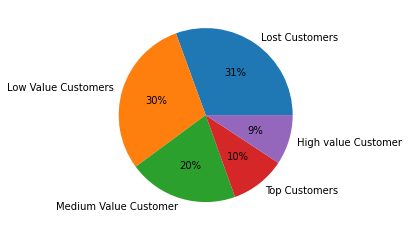

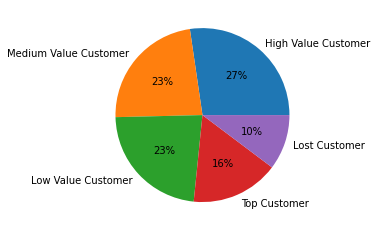

In [ ]:
# Visualisasi Pie Chart RFM Model 1
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Visualisasi Pie Chart RFM Model 2
plt.pie(RFM_Segment.customer_segment.value_counts(),
        labels=RFM_Segment.customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

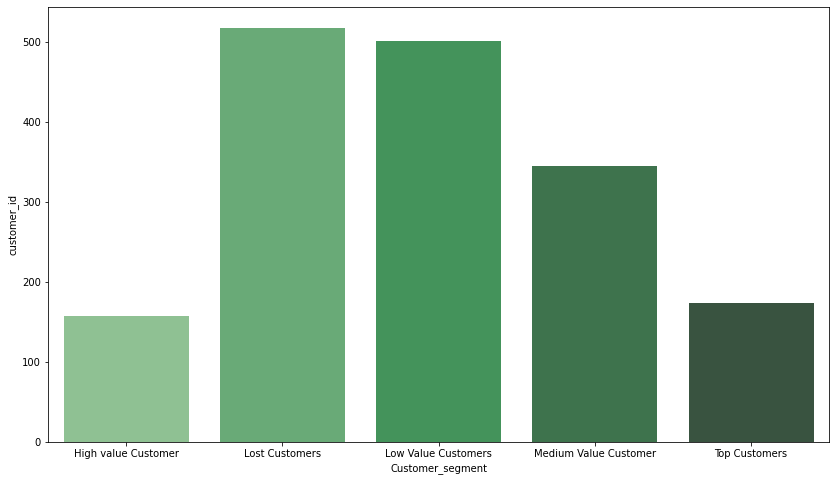

In [ ]:
sql = rfm_df.groupby('Customer_segment').nunique().reset_index()

plt.figure(figsize=(14,8))
sns.barplot(data=sql, x='Customer_segment',y='customer_id', palette="Greens_d")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

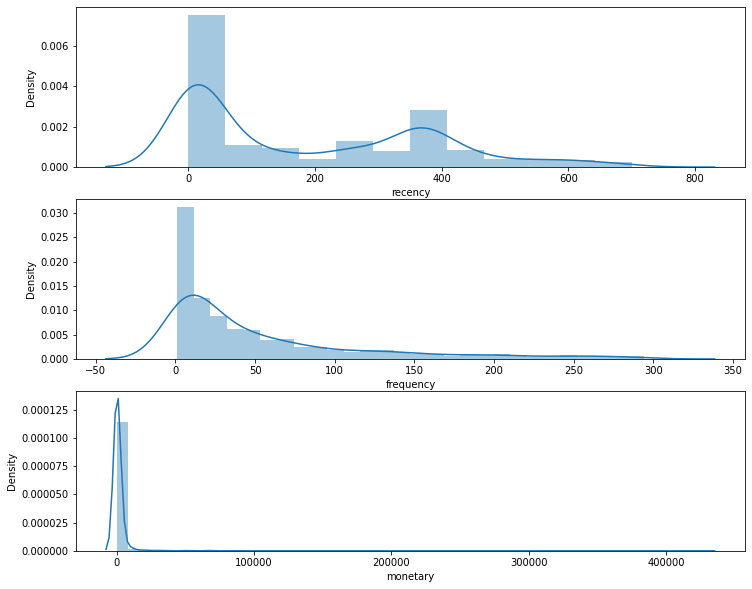

In [ ]:
# Distribusi RFM

plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(rfm_df['recency'])
plt.subplot(3, 1, 2); sns.distplot(rfm_df['frequency'])
plt.subplot(3, 1, 3); sns.distplot(rfm_df['monetary'])
plt.show()

In [ ]:
rfm_df.head()
rfm_df_clone = rfm_df[['customer_id', 'recency', 'frequency', 'monetary']]

In [ ]:
# RFM Normalized
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df_clone)
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized

,0,1,2,3
0,-1.349904,1.323424,-0.782769,-0.123355
1,-1.348489,-0.811512,-0.661008,-0.123277
2,-1.344242,1.339045,-0.752329,-0.123362
3,-1.341411,-0.806305,-0.097866,-0.112522
4,-1.338580,-0.801098,-0.615348,-0.122383
...,...,...,...,...
1690,3.107762,-0.967727,-0.737108,-0.123264
1691,3.110593,0.255956,-0.797989,-0.123369
1692,3.127580,-0.967727,-0.767549,-0.114382
1693,3.145983,-0.967727,-0.767549,-0.121880


# **Cluster**

Text(0, 0.5, 'Inertia')

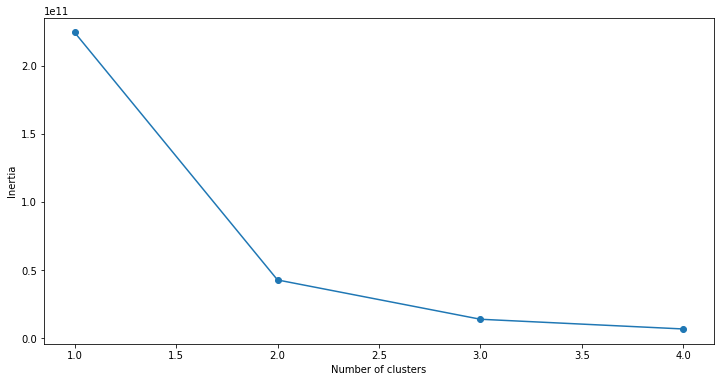

In [ ]:
SSE = []
for cluster in range(1,5):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(rfm_df_clone)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,5), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_normalized)

KMeans(max_iter=50, n_clusters=2)

In [ ]:
ssd = []

range_n_cluster = [1,2]

for num_clusters in range_n_cluster: 
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    ssd.append(kmeans.inertia_)

In [ ]:
# rfm_normalized['cluster'] = kmeans.labels_
rfm_df_clone['cluster'] = kmeans.labels_
rfm_df_clone.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_id,recency,frequency,monetary,cluster
0,1,440,2,0.19,1
1,2,30,10,1.09,0
2,5,443,4,0.11,1
3,7,31,47,124.59,0
4,9,32,13,11.35,0


In [ ]:
rfm_df_clone['cluster'].unique()

array([1, 0], dtype=int32)

In [ ]:
y_kmeans = kmeans.fit_predict(rfm_normalized)
y_kmeans

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
centroids  = kmeans.cluster_centers_ 

# Plot Cluster Customer

In [ ]:
rfm_df_clone.head()

NameError: ignored

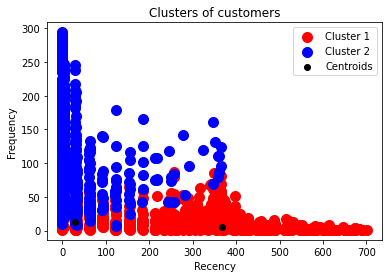

In [ ]:
#Visualizing all the clusters 
X = rfm_df_clone[['recency', 'frequency']].values
K=2
x = rfm_df_clone[['recency', 'frequency']]
Centroids = (x.sample(n=K))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(Centroids["recency"],Centroids["frequency"], c='black', label = 'Centroids')
#plt.scatter(centroids[:, 0], centroids[:, 1], s = 300, c = 'yellow', label = 'Centroids')

plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()


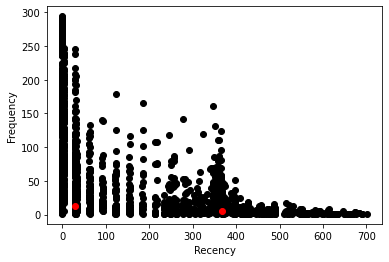

In [ ]:
#  Plot Cluster nasabah berdasarkan recency dan frequency
K=2
X = rfm_df_clone[['recency', 'frequency']]
# Select random observation as centroids
plt.scatter(X["recency"],X["frequency"],c='black')
plt.scatter(Centroids["recency"],Centroids["frequency"],c='red')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

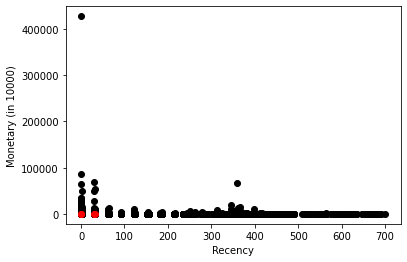

In [ ]:
#  Plot Cluster nasabah berdasarkan recency dan frequency
K=4
X = rfm_df_clone[['recency', 'monetary']]
# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.scatter(X["recency"],X["monetary"],c='black')
plt.scatter(Centroids["recency"],Centroids["monetary"],c='red')
plt.xlabel('Recency')
plt.ylabel('Monetary (in 10000)')
plt.show()

In [ ]:
# REGRESI LINIER ,  Mencocokan R dan F, F dan M, R dan M
data_rf = rfm_df2_normalized[['recency', 'frequency']]
data_fm = rfm_df2_normalized[['frequency', 'monetary']]
data_rm = rfm_df2_normalized[['recency', 'monetary']]

data_rfm_all = rfm_df2_normalized[['recency', 'frequency', 'monetary']]

In [ ]:
# data_rf.describe()
# data_fm.describe()
data_rm.describe()

,recency,monetary
count,1695.000000,1695.000000
mean,0.265115,0.003313
std,0.274037,0.026864
min,0.000000,0.000000
25%,0.004280,0.000022
50%,0.132668,0.000177
75%,0.520685,0.001089
max,1.000000,1.000000


In [ ]:
# R dan M
x_rm = data_rm
y = y_kmeans

# F dan M

x_fm = data_fm

# R dan F
x_rf = data_rf

# RFM
x_rfm = data_rfm_all.iloc[:, :-1].values


In [ ]:
print(x_rf)

       recency  frequency
0     0.627675   0.003413
1     0.042796   0.030717
2     0.631954   0.010239
3     0.044223   0.156997
4     0.045649   0.040956
...        ...        ...
1690  0.000000   0.013652
1691  0.335235   0.000000
1692  0.000000   0.006826
1693  0.000000   0.006826
1694  0.335235   0.000000

[1695 rows x 2 columns]


In [ ]:

testsize = 0.25
# Training R dan F
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y, test_size=testsize, random_state = 0)

# Training F dan M
x_train_fm, x_test_fm, y_train_fm, y_test_fm = train_test_split(x_fm, y, test_size=testsize, random_state = 0)

# Training R dan M
x_train_rm, x_test_rm, y_train_rm, y_test_rm = train_test_split(x_rm, y, test_size=testsize, random_state = 0)

# Training R dan M
x_train_rfm, x_test_rfm, y_train_rfm, y_test_rfm = train_test_split(x_rfm, y, test_size=testsize, random_state = 0)

In [ ]:
x_test_rf.size

848

In [ ]:
print(y_test_rf.size)

424


In [ ]:
from sklearn.linear_model import LinearRegression

# Regressor RF
regressor_rf = LinearRegression()
regressor_rf.fit(x_train_rf, y_train_rf)

# Regressor FM
regressor_fm = LinearRegression()
regressor_fm.fit(x_train_fm, y_train_fm)

# Regressor RM
regressor_rm = LinearRegression()
regressor_rm.fit(x_train_rm, y_train_rm)

# Regressor RFM
regressor_rfm = LinearRegression()
regressor_rfm.fit(x_train_rfm, y_train_rfm)


# Prediction RF
train_pred_y_rf = regressor_rf.predict(x_train_rf)
test_pred_y_rf = regressor_rf.predict(x_test_rf)

# Prediction FM
train_pred_y_fm = regressor_fm.predict(x_train_fm)
test_pred_y_fm = regressor_fm.predict(x_test_fm)

# Prediction RM
train_pred_y_rm = regressor_rm.predict(x_train_rm)
test_pred_y_rm = regressor_rm.predict(x_test_rm)

# Prediction RM
train_pred_y_rfm = regressor_rfm.predict(x_train_rfm)
test_pred_y_rfm = regressor_rfm.predict(x_test_rfm)

print('#Coef & Intercept FM')
print(regressor_fm.coef_)
print(regressor_fm.intercept_)

print('#Coef & Intercept RF')
print(regressor_rf.coef_)
print(regressor_rf.intercept_)

print('#Coef & Intercept RM')
print(regressor_rm.coef_)
print(regressor_rm.intercept_)

#Coef & Intercept FM
[ 1.5787457  -0.74444154]
0.12530668652443377
#Coef & Intercept RF
[-0.73023512  1.0739501 ]
0.40476080911984014
#Coef & Intercept RM
[-1.1843845   0.94117163]
0.7110000961875076


In [ ]:
# Import packages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Calculate MSE
mse_train_rf = np.sqrt(mean_squared_error(y_train_rf, train_pred_y_rf))
mse_test_rf = np.sqrt(mean_squared_error(y_test_rf, test_pred_y_rf))

# Print MSE
print('MSE train RF : {:.3f}; MSE test: {:.3f}'.format(mse_train_rf, mse_test_rf))

# Calculate R-squared and p-values RF
y_train_rf_ = np.array(y_train_rf)
ols_reg_rf = sm.OLS(y_train_rf, x_train_rf)
ols_reg_rf = ols_reg_rf.fit()


# Print OLS regression results
print(ols_reg_rf.summary())

MSE train RF : 0.306; MSE test: 0.313
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              1303.
Date:                Tue, 28 Jun 2022   Prob (F-statistic):                   2.53e-308
Time:                        12:27:58   Log-Likelihood:                         -513.78
No. Observations:                1271   AIC:                                      1032.
Df Residuals:                    1269   BIC:                                      1042.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

In [ ]:
mse_train_rm = np.sqrt(mean_squared_error(y_train_rm, train_pred_y_rm))
mse_test_rm = np.sqrt(mean_squared_error(y_test_rm, test_pred_y_rm))

# Print MSE
print('MSE train RF : {:.3f}; MSE test: {:.3f}'.format(mse_train_rm, mse_test_rm))

# Calculate R-squared and p-values RF
y_train_rm_ = np.array(y_train_rm)
ols_reg_rm = sm.OLS(y_train_rm, x_train_rm)
ols_reg_rm = ols_reg_rm.fit()


# Print OLS regression results
print(ols_reg_rm.summary())

MSE train RF : 0.365; MSE test: 0.360
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.029
Model:                            OLS   Adj. R-squared (uncentered):              0.028
Method:                 Least Squares   F-statistic:                              19.25
Date:                Tue, 28 Jun 2022   Prob (F-statistic):                    5.82e-09
Time:                        12:27:58   Log-Likelihood:                         -1204.2
No. Observations:                1271   AIC:                                      2412.
Df Residuals:                    1269   BIC:                                      2423.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

In [ ]:
mse_train_fm = np.sqrt(mean_squared_error(y_train_fm, train_pred_y_fm))
mse_test_fm = np.sqrt(mean_squared_error(y_test_fm, test_pred_y_fm))

# Print MSE
print('MSE train RF : {:.3f}; MSE test: {:.3f}'.format(mse_train_fm, mse_test_fm))

# Calculate R-squared and p-values RF
y_train_fm_ = np.array(y_train_fm)
ols_reg_fm = sm.OLS(y_train_fm, x_train_fm)
ols_reg_fm = ols_reg_fm.fit()


# Print OLS regression results
print(ols_reg_fm.summary())

MSE train RF : 0.349; MSE test: 0.367
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.673
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              1304.
Date:                Tue, 28 Jun 2022   Prob (F-statistic):                   1.58e-308
Time:                        12:27:58   Log-Likelihood:                         -513.31
No. Observations:                1271   AIC:                                      1031.
Df Residuals:                    1269   BIC:                                      1041.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

In [ ]:
#Predict RF
y_pred_rf = regressor_rf.predict(x_test_rf)

#Predict FM
y_pred_fm = regressor_fm.predict(x_test_fm)

#Predict RM
y_pred_rm = regressor_rm.predict(x_test_rm)

#Predict RFM
y_pred_rfm = regressor_rfm.predict(x_test_rfm)

In [ ]:
#Result RF 
res_df_rf = pd.DataFrame({
    'Data Sebenarnya' : y_test_rf, 
    'Data Prediksi' : y_pred_rf
})

#Result FM
res_df_fm = pd.DataFrame({
    'Data Sebenarnya' : y_test_fm, 
    'Data Prediksi' : y_pred_fm
})

#Result RM
res_df_rm = pd.DataFrame({
    'Data Sebenarnya' : y_test_rm, 
    'Data Prediksi' : y_pred_rm
})

#Result RM
res_df_rfm = pd.DataFrame({
    'Data Sebenarnya' : y_test_rfm, 
    'Data Prediksi' : y_pred_rfm
})


In [ ]:
x_test_rf

,recency,frequency
1018,0.000000,0.129693
6,0.221113,0.081911
107,0.004280,0.771331
34,0.045649,0.136519
1093,0.221113,0.010239
...,...,...
974,0.522111,0.075085
1108,0.587732,0.006826
77,0.514979,0.006826
913,0.650499,0.027304


In [ ]:
y_test_rf.size

424

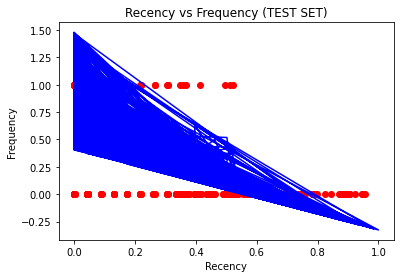

ValueError: ignored

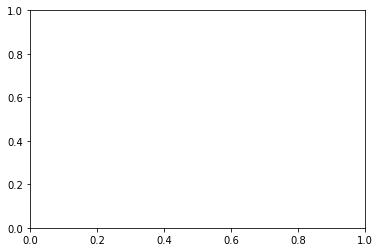

In [ ]:
# Visual Testset RF
plt.scatter(x_test_rf["recency"], x_test_rf["recency"], color='red')
plt.plot(x_train_rf["recency"], regressor_rf.predict(x_train_rf), color='blue')
plt.title('Recency vs Frequency (TEST SET)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# Training Set RF
plt.scatter(y_train_rf, x_train_rf, color='red')
plt.plot(x_train_rf, regressor_rf.predict(x_train_rf), color='blue')
plt.title('Recency vs Frequency (TRAINING SET)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# TODO dibalik supaya data nya kelihatan naik

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

In [ ]:
# Visual Testset RM
plt.scatter(x_test_rm, y_test_rm, color='red')
plt.plot(x_train_rm, regressor_rm.predict(x_train_rm), color='blue')
plt.title('Recency vs Monetary (TEST SET)')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

# Training Set RM
plt.scatter(x_train_rm, y_train_rm, color='red')
plt.plot(x_train_rm, regressor_rm.predict(x_train_rm), color='blue')
plt.title('Recency vs Monetary (TRAINING SET)')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [ ]:
# Visual Testset FM
plt.scatter(x_test_fm, y_test_fm, color='red')
plt.plot(x_train_fm, regressor_fm.predict(x_train_fm), color='blue')
plt.title('Frequency vs Monetary (TEST SET)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Training Set FM
plt.scatter(x_train_fm, y_train_fm, color='red')
plt.plot(x_train_fm, regressor_fm.predict(x_train_fm), color='blue')
plt.title('Frequency vs Monetary (TRAINING SET)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [ ]:
# Visual Testset RFM
plt.scatter(x_test_rfm, y_test_rfm, color='red')
plt.plot(x_train_rfm, regressor_rfm.predict(x_train_rfm), color='blue')
plt.title('RFM (TEST SET)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Training Set FM
plt.scatter(x_train_fm, y_train_fm, color='red')
plt.plot(x_train_fm, regressor_fm.predict(x_train_fm), color='blue')
plt.title('Frequency vs Monetary (TRAINING SET)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [ ]:
from sklearn import metrics

print('### RF')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_rf, y_pred_rf))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_rf, y_pred_rf))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_rf, y_pred_rf)))

print('### FM')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_fm, y_pred_fm))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_fm, y_pred_fm))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_fm, y_pred_fm)))

print('### RM')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_rm, y_pred_rm))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_rm, y_pred_rm))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_rm, y_pred_rm)))

#Calculate Linear Regression

In [ ]:
# Instantiate linear regression model
linreg = LinearRegression()
# Fit the model
model_new = linreg.fit(x_train_rf, y_train_rf)
# Make predictions
train_pred_y_rf = model_new.predict(x_train_rf)
test_pred_y_rf = model_new.predict(x_test_rf)

# Look at the models' coefficients 
model_new.coef_
# Look at the model's intercept
model_new.intercept_

In [ ]:
# Import packages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Calculate MSE
mse_train = np.sqrt(mean_squared_error(y_train_rf, train_pred_y_rf))
mse_test = np.sqrt(mean_squared_error(y_test_rf, test_pred_y_rf))
# Print MSE
print('MSE train: {:.3f}; MSE test: {:.3f}'.format(mse_train, mse_test))

# Calculate R-squared and p-values
y_train_rf = np.array(y_train_rf)
ols_reg = sm.OLS(y_train_rf, x_train_rf)
ols_reg = ols_reg.fit()
# Print OLS regression results
print(ols_reg.summary())

In [ ]:

# rfm_segment_clone
rfm_df_test2 = rfm_df[['recency', 'monetary', 'frequency']]
rfm_df_test2.head()

X = rfm_df_test2.iloc[:, :-1].values
Y = rfm_df_test2.iloc[:,1].values


x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X, Y, test_size=0.25, random_state = 0)


# # # # Instantiate linear regression model
# linearModel = LinearRegression()
# # # Fit the model
# model_new2 = linearModel.fit(x_train_new, y_train_new)

# train_prediction_y = model_new2.predict(x_train_new)
# test_prediction_y = model_new2.predict(x_test_new)

# model_new2.coef_

In [ ]:
x_pred_new = model_new2.predict(x_test_new)

result_new = pd.DataFrame({
    'Data Sebenarnya' : x_pred_new, 
    'Data Prediksi' : x_pred_new
})


In [ ]:
# Visual Testset FM
plt.scatter(x_test_new, y_test_new, color='red')
plt.plot(x_train_new, model_new2.predict(x_train_new), color='blue')
plt.title('X x X(TEST SET)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

# Training Set FM
plt.scatter(x_train_fm, y_train_fm, color='red')
plt.plot(x_train_fm, regressor_fm.predict(x_train_fm), color='blue')
plt.title('Frequency vs Monetary (TRAINING SET)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()